In [232]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import seaborn as sns
from sklearn.linear_model import LinearRegression

%matplotlib notebook

In [275]:
def target_function(point):
    x = point[0]**2 + point[1]**2 - 0.6
    return int(np.sign(x))


def create_sign_func(vector):
    if vector.size == 3:
        def sign_func(p):
            x = np.dot(vector, [1, p[0], p[1]])
            return int(np.sign(x))
        return sign_func
    elif vector.size == 6:
        def sign_func(p):
            w = [1, p[0], p[1], p[0]*p[1], p[0]**2, p[1]**2]
            x = np.dot(vector, w)
            return int(np.sign(x))
        return sign_func


def convert_to_explicit_eq(vector):
    return np.poly1d([-vector[1]/vector[2], -vector[0]/vector[2]])


def generate_sample(sample_size):
    sample = pd.DataFrame({
        'X1': np.random.uniform(-1, 1, sample_size),
        'X2': np.random.uniform(-1, 1, sample_size),
    })
    sample['X1X2'] = sample[['X1', 'X2']].apply(lambda p: p[0]*p[1], axis = 1)
    sample['X1^2'] = sample[['X1']].apply(lambda x1: x1**2, axis = 1)
    sample['X2^2'] = sample[['X2']].apply(lambda x2: x2**2, axis = 1)
    sample['Sign'] = sample[['X1', 'X2']].apply(target_function, axis = 1)
    random_rows = np.random.choice(sample.shape[0], int(0.1 * sample_size))
    for row in random_rows:
        sample.set_value(row, 'Sign', -1 * sample.Sign[row])
    return sample

In [251]:
sample = generate_sample(1000)
sample.head()

,X1,X2,X1X2,X1^2,X2^2,Sign
0,0.288361,-0.842462,-0.242933,0.083152,0.709742,1
1,0.268281,-0.235921,-0.063293,0.071975,0.055659,-1
2,0.418349,-0.785032,-0.328417,0.175016,0.616276,1
3,-0.806048,0.688716,-0.555138,0.649713,0.474330,1
4,0.676671,-0.032952,-0.022298,0.457884,0.001086,-1


In [252]:
regr = LinearRegression()
regr.fit(sample[['X1', 'X2']], sample.Sign)
linear_explicit = convert_to_explicit_eq([regr.intercept_, regr.coef_[0], regr.coef_[1]])
regr.fit(sample[['X1', 'X2', 'X1X2', 'X1^2', 'X2^2']], sample.Sign)
feature_vector = np.append(regr.intercept_, regr.coef_)
print(linear_explicit)
print(feature_vector)

 
-0.7829 x - 0.5381
[-1.01141425  0.01490304  0.02769791  0.00944875  1.5668895   1.57734274]


<IPython.core.display.Javascript object>


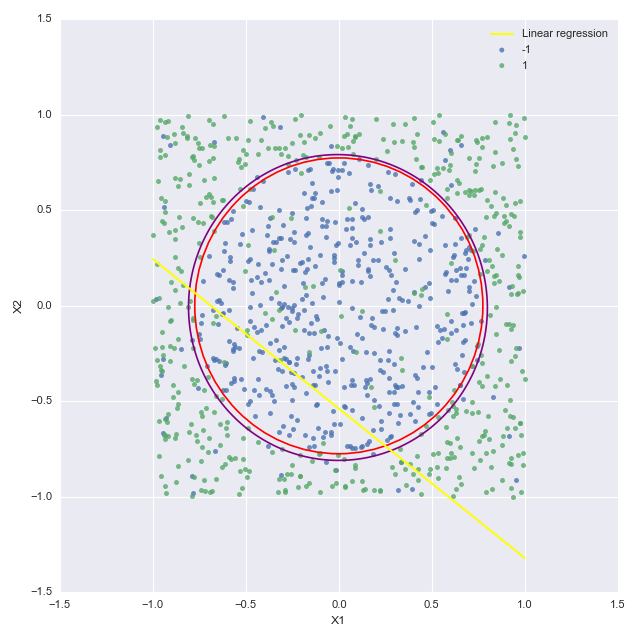

In [253]:
sns.lmplot('X1', 'X2', data = sample, hue='Sign', fit_reg=False, legend_out=False, size = 8)
circle = plt.Circle((0, 0), np.sqrt(0.6), color='r', fill=False, linewidth=1.5, label="Target function (circle)")
plt.gcf().gca().add_artist(circle)
x = np.linspace(-1, 1, 100)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.plot(x, linear_explicit(x), color='yellow', label='Linear regression')
X, Y = np.mgrid[-1:1:100j, -1:1:100j]
plt.contour(X, Y, feature_vector[0] + feature_vector[1]*X + feature_vector[2]*Y + feature_vector[3]*X*Y 
            + feature_vector[4]*X**2 + feature_vector[5]*Y**2, [0], colors='purple', linewidths=1.5)
plt.legend()


In [254]:
def  run_experiment_without_transformation(sample_size):
    runs = 10
    ein = 0
    
    for _ in range(runs):
        regr = LinearRegression()
        sample = generate_sample(sample_size)
        regr.fit(sample[['X1', 'X2']], sample.Sign)
        
        regr_sign_func = create_sign_func(np.array([regr.intercept_, regr.coef_[0], regr.coef_[1]]))
        
        # In sample error
        sample['Regr_sign'] = sample[['X1', 'X2']].apply(regr_sign_func, axis = 1)
        ein += sample[sample.Sign != sample.Regr_sign].shape[0] / sample_size
    
    ein /= runs
    print("Avarage in sample error: ", ein)

In [255]:
run_experiment_without_transformation(1000)

Avarage in sample error:  0.5130000000000001


In [278]:
def  run_experiment_with_transformation(sample_size):
    runs = 100
    eout = 0
    average_feature_vec=np.array([0.]*6)
    for _ in range(runs):
        regr = LinearRegression()
        sample = generate_sample(sample_size)
        regr.fit(sample[['X1', 'X2', 'X1X2', 'X1^2', 'X2^2']], sample.Sign)
        feature_vector = np.append(regr.intercept_, regr.coef_)
        nonlinear_sign_func = create_sign_func(feature_vector)
        average_feature_vec += feature_vector
        
        # Out of sample error
        out_of_sample_size = 1000
        out_of_sample = pd.DataFrame({
            'X': np.random.uniform(-1, 1, out_of_sample_size),
            'Y': np.random.uniform(-1, 1, out_of_sample_size),
        })

        out_of_sample['Sign'] = out_of_sample[['X', 'Y']].apply(target_function, axis = 1)
        out_of_sample['Nonlinear_sign'] = out_of_sample[['X', 'Y']].apply(nonlinear_sign_func, axis = 1)
        eout += out_of_sample[out_of_sample.Sign != out_of_sample.Nonlinear_sign].shape[0] / out_of_sample_size
    
    eout /= runs
    average_feature_vec /= runs
    print("Avarage out of sample error: ", eout)
    print("Avarage coef.: ", average_feature_vec)

In [279]:
run_experiment_with_transformation(1000)

Avarage out of sample error:  0.03388999999999998
Avarage coef.:  [ -1.01714772e+00  -1.40178804e-03  -6.43504895e-03  -9.24917704e-04
   1.57798978e+00   1.60639689e+00]
